In [16]:
import os
import torch

# set params
ae_path = '/home/jeeves/JJ_Projects/klara_models/flux_dev/train-model/ae.safetensors'
transformer_path = '/home/jeeves/JJ_Projects/klara_models/flux_dev/train-model/flux1-dev.safetensors'
os.environ['FLUX_DEV'] = transformer_path
os.environ['AE'] = ae_path

width, height = 1024, 1024
device = torch.device('cuda')
dtype = torch.bfloat16
seed = 42
prompt = "a cute boy running on the street"

guidance = 3.5
steps = 20

In [2]:
from flux.util import load_ae, load_clip, load_flow_model, load_t5

# load models
ae = load_ae(name='flux-dev', device=device, hf_download=False)
clip = load_clip(device=device)
t5 = load_t5(device=device, max_length=512)
transformer = load_flow_model(name='flux-dev', device=device, hf_download=False)
torch.cuda.empty_cache()



Init AE


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Init model
Loading checkpoint


x_T shape: torch.Size([1, 16, 128, 128])
img_ids shape: torch.Size([1, 4096, 3])
txt shape: torch.Size([1, 512, 4096])
txt_ids shape: torch.Size([1, 512, 3])
clip vec shape: torch.Size([1, 768])
timesteps
[1.0, 0.983608067035675, 0.9660138487815857, 0.9470800161361694, 0.9266473650932312, 0.9045307636260986, 0.880513072013855, 0.8543381690979004, 0.8257015943527222, 0.7942392230033875, 0.7595109343528748, 0.7209802865982056, 0.677986741065979, 0.6297070980072021, 0.5751029849052429, 0.5128440856933594, 0.44119977951049805, 0.3578745722770691, 0.2597584128379822, 0.14252935349941254, 0.0]
x_0 shape: torch.Size([1, 4096, 64])
x shape after unpacked torch.Size([1, 16, 128, 128])


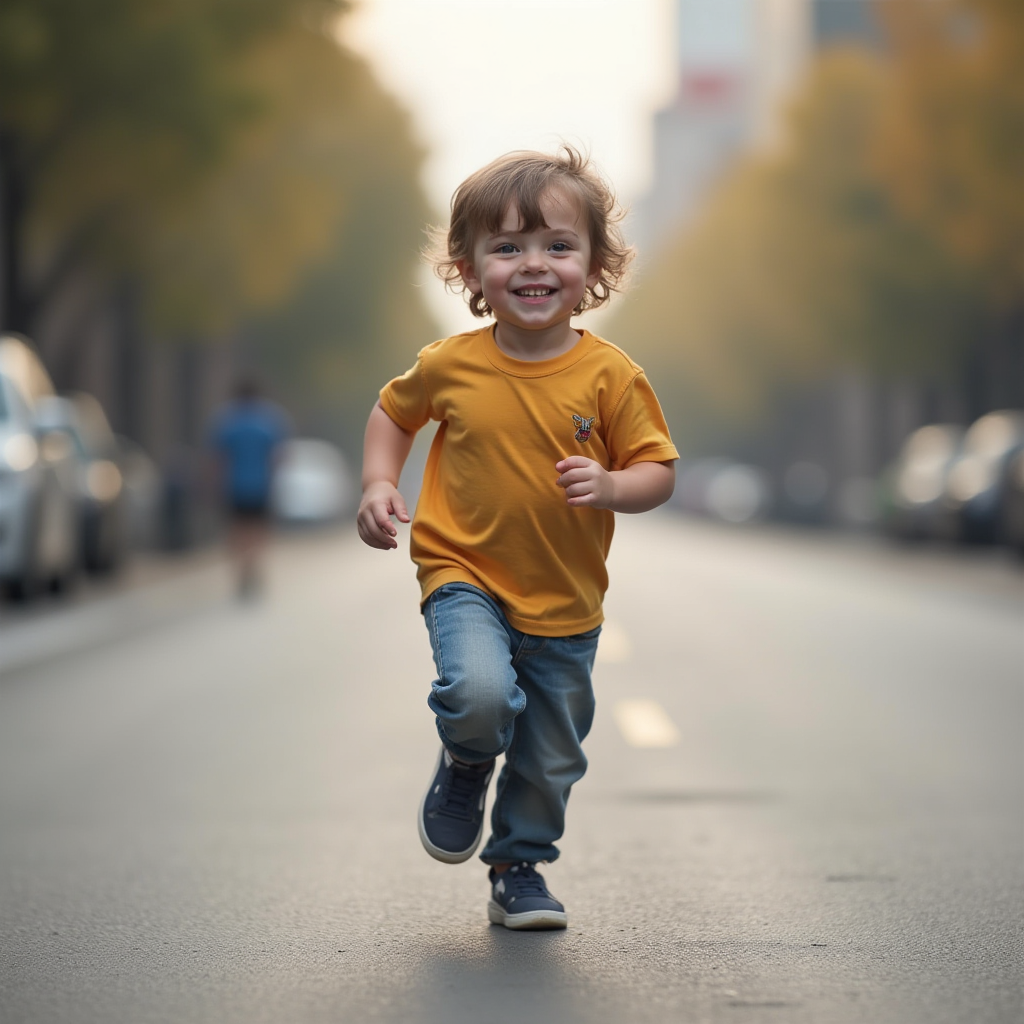

In [17]:

from PIL import Image
import math
import einops
from typing import Callable
# 现在我们需要一步步自己实现下面的采样函数
# from flux.sampling import get_noise, prepare, denoise, get_schedule, unpack


def time_shift(mu: float, sigma: float, t: torch.Tensor):
    return math.exp(mu) / (math.exp(mu) + (1 / t - 1) ** sigma)

def get_lin_function(
    x1: float = 256, y1: float = 0.5, x2: float = 4096, y2: float = 1.15
) -> Callable[[float], float]:
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    return lambda x: m * x + b



with torch.inference_mode():
    # 获取噪声
    # x_T = get_noise(num_samples=1, height=height, width=width, device=device, dtype=dtype, seed=seed)
    x_T = torch.randn(
        1,
        16,  # channels
        # 需要能够被 16 整除 ？ TODO  这里的 2 是为了下面能被 块的尺寸 pw/ph 整除？
        2 * math.ceil(height / 16),  
        2 * math.ceil(width / 16),
        device=device,
        dtype=dtype,
        generator=torch.Generator(device=device).manual_seed(seed),
    )
    print("x_T shape:", x_T.shape)  # [1, 16, 128, 128]

    # 准备输入：img，img_ids，txt，txt_ids
    # inputs_dict = prepare(t5, clip, x_T, prompt)
    bs, c, h, w = x_T.shape

    # 图块化  [1, 16, 128(64 * 2), 128] -> [1, 4096(64 * 64), 64(16 * 2 * 2)]   (bs, img_token_seq_len, dim_in)
    # ph/pw 块高、宽, 都取 2。
    # 这里 patch 的宽高都是写死 2 的话，是不是图块化/反图块化写在模型内部比较合理？
    x_T_patchified = einops.rearrange(x_T, "b c (h ph) (w pw) -> b (h w) (c ph pw)", ph=2, pw=2)
    img = x_T_patchified

    # img_ids TODO   这是干嘛？？？？？？？？？
    img_ids = torch.zeros(h // 2, w // 2, 3)
    img_ids[..., 1] = img_ids[..., 1] + torch.arange(h // 2)[:, None]
    img_ids[..., 2] = img_ids[..., 2] + torch.arange(w // 2)[None, :]
    img_ids = einops.repeat(img_ids, "h w c -> b (h w) c", b=bs)
    img_ids = img_ids.to(device)
    print('img_ids shape:', img_ids.shape)  # [bs, img_token_seq_len, 3] [1, 4096, 3]

    # 文本条件嵌入
    txt = t5(prompt)
    print('txt shape:', txt.shape)  # [bs, t5_seq_len, t5_dim]  [1, 512, 4096]

    # txt_ids
    txt_ids = torch.zeros(bs, txt.shape[1], 3)
    txt_ids = txt_ids.to(device)
    print('txt_ids shape:', txt_ids.shape)  # [bs, t5_seq_len, 3]   [1, 512, 3]

    vec = clip(prompt)
    print('clip vec shape:', vec.shape)  # [bs, clip_dim]    [1, 768]

    # 获取采样时间步
    # timesteps = get_schedule(steps, inputs_dict["img"].shape[1], shift=True)
    timesteps = torch.linspace(1, 0, steps+1)
    shift = True
    if shift:
        base_shift = 0.5
        max_shift = 1.15
        image_seq_len = img.shape[1]
        mu = get_lin_function(y1=base_shift, y2=max_shift)(image_seq_len)
        timesteps = time_shift(mu, 1.0, timesteps)

    timesteps = timesteps.tolist()
    print('timesteps')
    print(timesteps)

    # 去噪循环
    # x = denoise(transformer, **inputs_dict, guidance=guidance_scale, timesteps=timesteps)

    # cfg 蒸馏的结果，直接将 guidance 标量值输入模型。只有 dev 模型有 guidance，schnell 模型没有,
    guidance_vec = torch.full((img.shape[0], ), guidance, device=device, dtype=img.dtype)
    for t_curr, t_prev in zip(timesteps[: -1], timesteps[1: ]):  # TODO 为啥这样写，和 RF 采样公式有关？？？
        t_vec = torch.full((img.shape[0], ), t_curr, device=device, dtype=img.dtype)
        pred = transformer(
            img=img, img_ids=img_ids,
            txt=txt, txt_ids=txt_ids,
            y=vec,
            timesteps=t_vec,
            guidance=guidance_vec
        )

        img = img + (t_prev - t_curr) * pred   # RF 的采样公式 ？？？？？？？？
    x = img

    print("x_0 shape:", img.shape)

    # 反图块化
    # x = unpack(x.float(), height, width)
    x = einops.rearrange(x, "b (h w) (c ph pw) -> b c (h ph) (w pw)", h=64, w=64, ph=2, pw=2)
    print("x shape after unpacked", x.shape)

    with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
        x = ae.decode(x)

    x = x.clamp(-1, 1)
    x = einops.rearrange(x[0], "c h w -> h w c")
    img = Image.fromarray((127.5 * (x + 1.0)).cpu().byte().numpy())

img
